In [ ]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [ ]:
import os
import pandas as pd

benign_dirs = [
    r'/content/drive/MyDrive/MyWork/6-МНК/DATASET/Bengin cases'
]

Malignant_dir = [ r'/content/drive/MyDrive/MyWork/6-МНК/DATASET/Malignant cases']

Normal_dirs = [
    r'/content/drive/MyDrive/MyWork/6-МНК/DATASET/Normal cases'
]

filepaths = []
labels = []
dict_lists = [benign_dirs, Malignant_dir, Normal_dirs]
class_labels = ['benign', 'Malignant', 'Normal']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Lung_data = pd.concat([Fseries, Lseries], axis=1)
Lung_df = pd.DataFrame(Lung_data)
print(Lung_df.head())
print(Lung_df["labels"].value_counts())

                                           filepaths  labels
0  /content/drive/MyDrive/MyWork/6-МНК/DATASET/Be...  benign
1  /content/drive/MyDrive/MyWork/6-МНК/DATASET/Be...  benign
2  /content/drive/MyDrive/MyWork/6-МНК/DATASET/Be...  benign
3  /content/drive/MyDrive/MyWork/6-МНК/DATASET/Be...  benign
4  /content/drive/MyDrive/MyWork/6-МНК/DATASET/Be...  benign
Malignant    561
Normal       416
benign       120
Name: labels, dtype: int64


In [ ]:
Lung_df.shape

(1097, 2)

In [ ]:
train_images, test_images = train_test_split(Lung_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Lung_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(877, 2)
(330, 2)
(220, 2)
(767, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=4,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 877 validated image filenames belonging to 3 classes.
Found 330 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Malignant', 'Normal', 'benign']


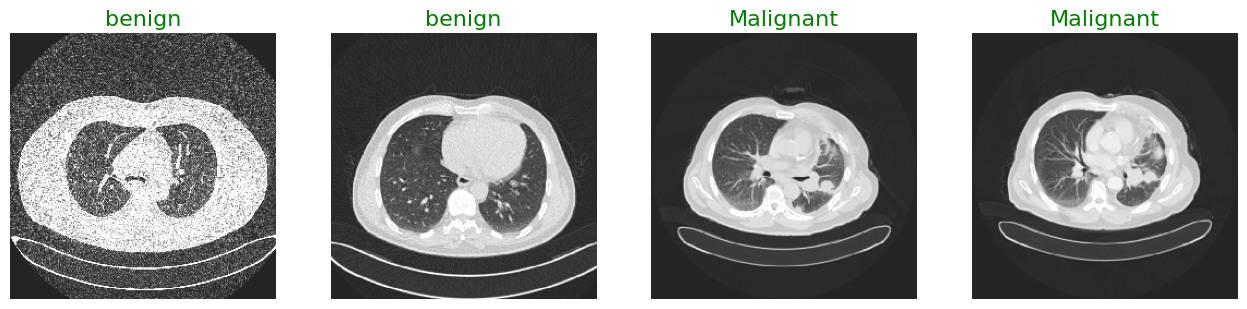

In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 73, 73, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                        

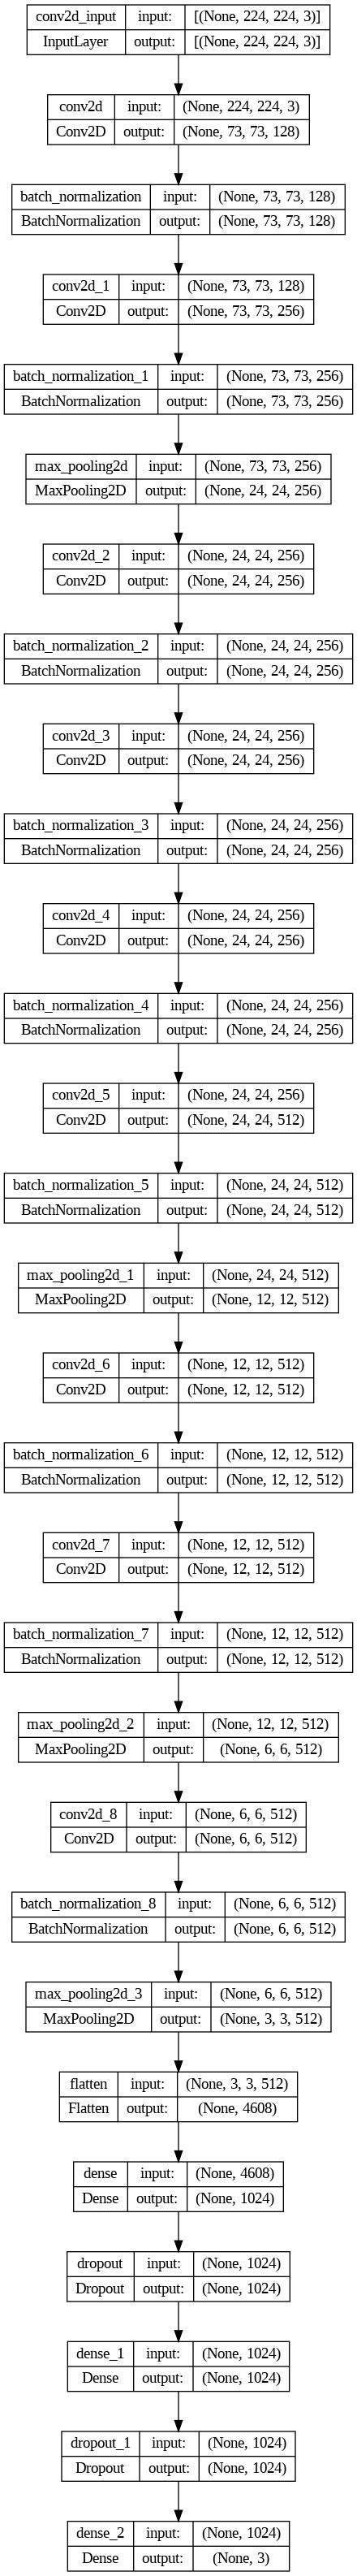

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(train, epochs=20, validation_data=val, verbose=1)

Epoch 1/20
220/220 [==============================] - 977s 4s/step - loss: 1.5576 - accuracy: 0.5906 - val_loss: 0.9160 - val_accuracy: 0.5000
Epoch 2/20
220/220 [==============================] - 896s 4s/step - loss: 0.8157 - accuracy: 0.7115 - val_loss: 0.5261 - val_accuracy: 0.8000
Epoch 3/20
220/220 [==============================] - 892s 4s/step - loss: 0.5045 - accuracy: 0.8039 - val_loss: 0.2741 - val_accuracy: 0.8818
Epoch 4/20
220/220 [==============================] - 865s 4s/step - loss: 0.3125 - accuracy: 0.8883 - val_loss: 0.2262 - val_accuracy: 0.9000
Epoch 5/20
220/220 [==============================] - 891s 4s/step - loss: 0.2506 - accuracy: 0.9019 - val_loss: 0.1980 - val_accuracy: 0.9000
Epoch 6/20
220/220 [==============================] - 890s 4s/step - loss: 0.1846 - accuracy: 0.9441 - val_loss: 0.2142 - val_accuracy: 0.9091
Epoch 7/20
220/220 [==============================] - 889s 4s/step - loss: 0.1351 - accuracy: 0.9464 - val_loss: 0.1199 - val_accuracy: 0.9545

In [ ]:
model.evaluate(test, verbose=1)

83/83 [==============================] - 84s 1s/step - loss: 0.0372 - accuracy: 0.9879


[0.03720703721046448, 0.9878787994384766]

In [ ]:
model.save("/content/drive/MyDrive/MyWork/6-МНК/Custom.keras")

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

val_preds = model.predict(val)
val_preds_classes = np.argmax(val_preds, axis=1)
true_classes = val.classes

conf_mat = confusion_matrix(true_classes, val_preds_classes)
class_report = classification_report(true_classes, val_preds_classes)

print("Confusion Matrix:")
print(conf_mat)
print("\nClassification Report:")
print(class_report)

55/55 [==============================] - 56s 1s/step
Confusion Matrix:
[[109   0   0]
 [  1  81   0]
 [  0   3  26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       109
           1       0.96      0.99      0.98        82
           2       1.00      0.90      0.95        29

    accuracy                           0.98       220
   macro avg       0.99      0.96      0.97       220
weighted avg       0.98      0.98      0.98       220



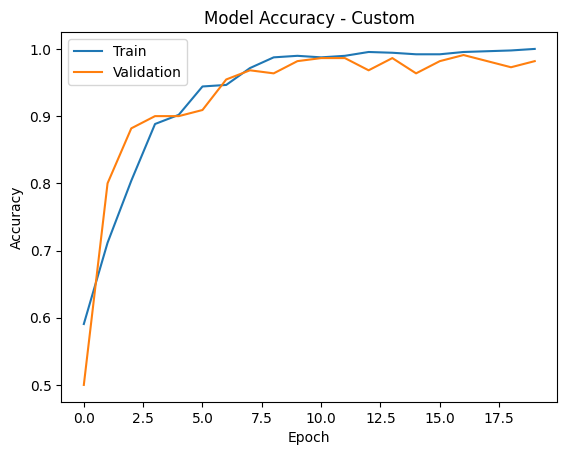

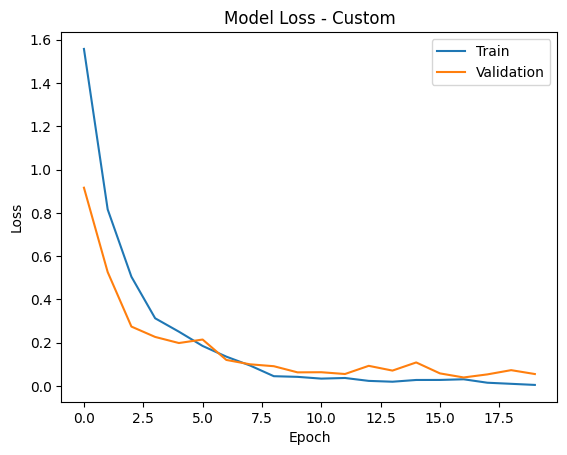

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy - Custom')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss - Custom')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
history.history['val_accuracy']

[0.5,
 0.800000011920929,
 0.8818181753158569,
 0.8999999761581421,
 0.8999999761581421,
 0.9090909361839294,
 0.9545454382896423,
 0.9681817889213562,
 0.9636363387107849,
 0.9818181991577148,
 0.9863636493682861,
 0.9863636493682861,
 0.9681817889213562,
 0.9863636493682861,
 0.9636363387107849,
 0.9818181991577148,
 0.9909090995788574,
 0.9818181991577148,
 0.9727272987365723,
 0.9818181991577148]

In [ ]:
history.history['val_loss']

[0.9160347580909729,
 0.5260586738586426,
 0.27408653497695923,
 0.2262263149023056,
 0.1980435848236084,
 0.21419715881347656,
 0.11991436779499054,
 0.09963789582252502,
 0.09091329574584961,
 0.06248066574335098,
 0.06306368857622147,
 0.05487322434782982,
 0.09263219684362411,
 0.07065504044294357,
 0.10832517594099045,
 0.05770307406783104,
 0.03889773413538933,
 0.053092192858457565,
 0.07266168296337128,
 0.05474112555384636]